In [187]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torchvision.transforms import v2 as trans2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import math

## Hyperparameters

In [188]:
epochs = 250
learning_rate = 0.00004
batch_size = 64
early_stopping_patience = 50


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the Datasets and setup the Data Loaders (with data augmentation)

In [189]:
transform_normal = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((250, 250)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(55),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop to a smaller size and resize back
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Random perspective transformation
    # transforms.Normalize(mean = mean, std = std) # Takes each value for the channel, subtracts the mean and divides by the standard deviation (value - mean) / std
])

# Define the transformations
transformations1 = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((250, 250))])

# Load the dataset
training_dataset = torchvision.datasets.Flowers102(root='./data', split="train",
                                                   download=True, transform=transform_train)
testing_dataset = torchvision.datasets.Flowers102(root='./data', split="test",
                                                  download=True, transform=transformations1)
validation_dataset = torchvision.datasets.Flowers102(root='./data', split="val",
                                                     download=True, transform=transformations1)

# Create the dataloaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

## Create The Model

In [190]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.flatten = nn.Flatten()
    self.relu = nn.PReLU()
    
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(16),
        nn.PReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(32),
        nn.PReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(64),
        nn.PReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.PReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(256),
        nn.PReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.layer6 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(256),
        nn.PReLU()
    )
    
    # self.fc1 = nn.Linear(256 * 3 * 3, 1024)
    self.fc1 = nn.Linear(256 * 7 * 7, 512)
    self.drop = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 102)  # Output layer for 102 classes

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = self.layer6(x)
    
    x = self.flatten(x)
    x = self.fc1(x)
    # x = self.drop(x)
    x = self.fc2(x)
    # x = self.drop(x)
    x = self.fc3(x)
    # x = self.drop(x)
    # x = self.fc2(x)
    # x = self.relu(x)
    # x = self.fc3(x)
    return x


In [191]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=8)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10, verbose=True)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


## Network Accuracy Tests (Validation and Testing)

In [192]:
def NetworkAccuracyOnValidation():
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        # num_class_correct = [0 for i in range(102)]
        # num_class_samples = [0 for i in range(102)]
        total_correct = 0
        total_samples = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            # for i in range(len(labels)):
            #     label = labels[i]
            #     pred = predictions[i]
            #     if label == pred:
            #         num_class_correct[label] += 1
            #     num_class_samples[label] += 1

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = 100. * val_correct / val_total
    
    return val_epoch_loss, val_epoch_acc

def NetworkAccuracyOnTesting():
    model.eval()
    total_correct = 0
    total_samples = 0
    num_class_correct = [0] * 102
    num_class_samples = [0] * 102
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predictions = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += predictions.eq(labels).sum().item()
            
            c = (predictions == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                num_class_correct[label] += c[i].item()
                num_class_samples[label] += 1

            # for i in range(len(labels)):
            #     label = labels[i]
            #     pred = predictions[i]
            #     if (label == pred):
            #         num_class_correct[label] += 1
            #     num_class_samples[label] += 1

    acc = 100.0 * total_correct / total_samples
    print(f'Accuracy on testing set: {acc} %')

    for i in range(102):
        acc = 100.0 * num_class_correct[i] / num_class_samples[i]
        print(f'Accuracy of {i} : {acc} %')

## Training and Testing loop

In [193]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_accuracy_epoch = 0
best_accuracy = 0
no_improve_epochs = 0

for epoch in range(epochs):  # Loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        label_pred = model(images)
        loss = criterion(label_pred, labels)
        
        # Manually add L2 regularization
        # l2_loss = 0
        # for param in model.parameters():
        #     l2_loss += torch.sum(torch.pow(param, 2))
        # loss += 0.01 * l2_loss  # L2 regularization term
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = label_pred.max(1)
        # predicted = torch.max(label_pred, 1)[1]
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        batch_corr = (predicted == labels).sum()
        batch_acc = batch_corr.item() / len(images)
        
        
        # print(f"Epoch Number {epoch}, Index = {i}/{len(train_loader)-1}, Loss = {loss.item()}")
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    val_epoch_loss, val_epoch_acc = NetworkAccuracyOnValidation()
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')
    
    # scheduler.step(val_epoch_loss)
    scheduler.step()
    
    if (val_epoch_acc > best_accuracy):
        best_accuracy = val_epoch_acc
        best_accuracy_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
print(f"Best accuracy on validation split: {best_accuracy} at epoch {best_accuracy_epoch}")

model.load_state_dict(torch.load('best_model.pth'))
NetworkAccuracyOnTesting()


Epoch 1/250, Loss: 4.5943, Accuracy: 1.76%
Validation Loss: 4.6283, Validation Accuracy: 0.98%
Epoch 2/250, Loss: 4.3174, Accuracy: 5.39%
Validation Loss: 4.4525, Validation Accuracy: 4.80%
Epoch 3/250, Loss: 4.1234, Accuracy: 8.73%
Validation Loss: 4.0582, Validation Accuracy: 9.51%
Epoch 4/250, Loss: 3.9595, Accuracy: 12.35%
Validation Loss: 3.8545, Validation Accuracy: 10.98%
Epoch 5/250, Loss: 3.8245, Accuracy: 13.63%
Validation Loss: 3.7427, Validation Accuracy: 12.16%
Epoch 6/250, Loss: 3.7424, Accuracy: 14.41%
Validation Loss: 3.6862, Validation Accuracy: 12.94%
Epoch 7/250, Loss: 3.6925, Accuracy: 15.59%
Validation Loss: 3.6363, Validation Accuracy: 13.33%
Epoch 8/250, Loss: 3.5851, Accuracy: 19.02%
Validation Loss: 3.5881, Validation Accuracy: 15.49%
Epoch 9/250, Loss: 3.5441, Accuracy: 18.92%
Validation Loss: 3.5654, Validation Accuracy: 15.49%
Epoch 10/250, Loss: 3.4792, Accuracy: 21.76%
Validation Loss: 3.5313, Validation Accuracy: 16.57%
Epoch 11/250, Loss: 3.4838, Accurac

Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set
Label 2 found in test set


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


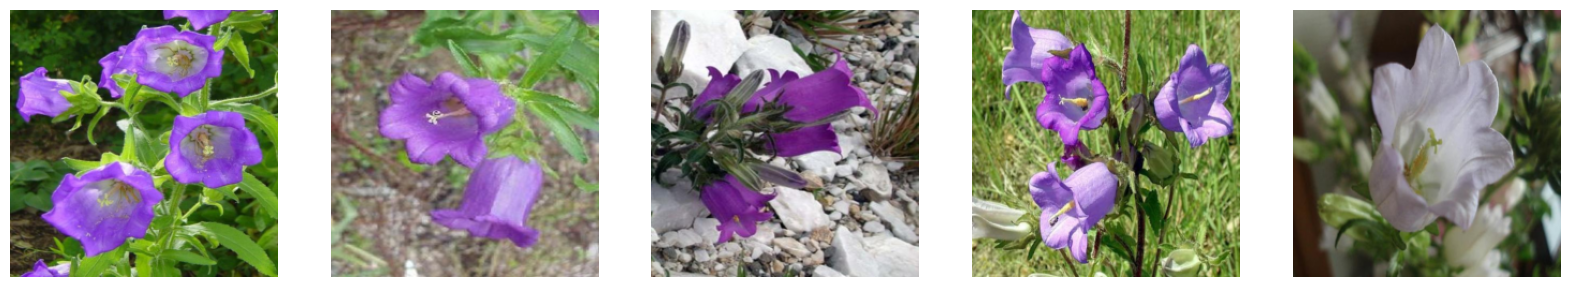

In [194]:
label_to_search = 2
images_to_display = []

for images, labels in test_loader:
    for i, label in enumerate(labels):
        if label == label_to_search:
            print(f"Label {label_to_search} found in test set")
            images_to_display.append(images[i])

import matplotlib.pyplot as plt

# Display the images

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    img = images_to_display[i].permute(1, 2, 0)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

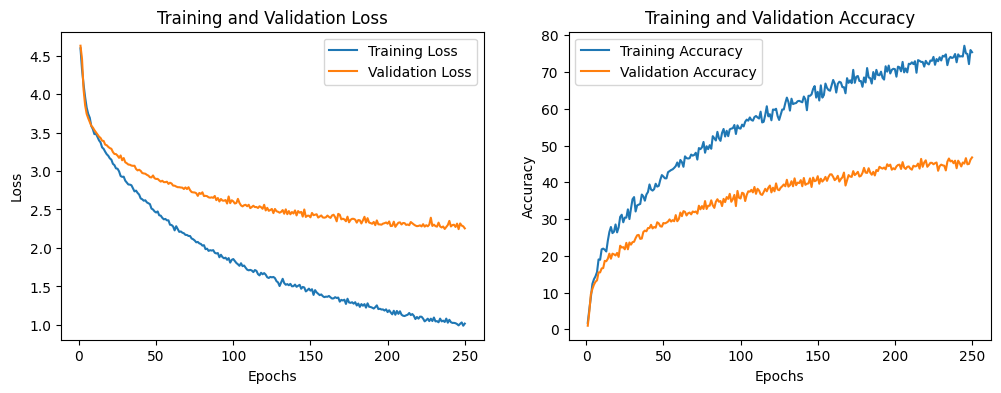

: 

In [195]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()
